From [here](https://www.dataquest.io/blog/web-scraping-beautifulsoup/)

To source data for data science projects, you’ll often rely on SQL and NoSQL databases, APIs, or ready-made CSV data sets.

The problem is that you can’t always find a data set on your topic, databases are not kept current and APIs are either expensive or have usage limits.

If the data you’re looking for is on an web page, however, then the solution to all these problems is web scraping.

In this tutorial we’ll learn to scrape multiple web pages with Python using BeautifulSoup and requests. We’ll then perform some simple analysis using pandas, and matplotlib.

## Scraping data for over 2000 movies

We want to analyze the distributions of [IMDB](https://www.imdb.com/) and [Metacritic](https://www.metacritic.com/) movie ratings to see if we find anything interesting. To do this, we’ll first scrape data for over 2000 movies.

It’s essential to identify the goal of our scraping right from the beginning. Writing a scraping script can take a lot of time, especially if we want to scrape more than one web page. We want to avoid spending hours writing a script which scrapes data we won’t actually need.

## Working out which pages to scrape

Once we’ve established our goal, we then need to identify an efficient set of pages to scrape.

We want to find a combination of pages that requires a relatively small number of requests. A request is what happens whenever we access a web page. We ‘request’ the content of a page from the server. The more requests we make, the longer our script will need to run, and the greater the strain on the server.

One way to get all the data we need is to compile a list of movie names, and use it to access the web page of each movie on both IMDB and Metacritic websites.

Since we want to get over 2000 ratings from both IMDB and Metacritic, we’ll have to make at least 4000 requests. If we make one request per second, our script will need a little over an hour to make 4000 requests. Because of this, it’s worth trying to identify more efficient ways of obtaining our data.

If we explore the IMDB website, we can discover a way to halve the number of requests. Metacritic scores are shown on the IMDB movie page, so we can scrape both ratings with a single request:

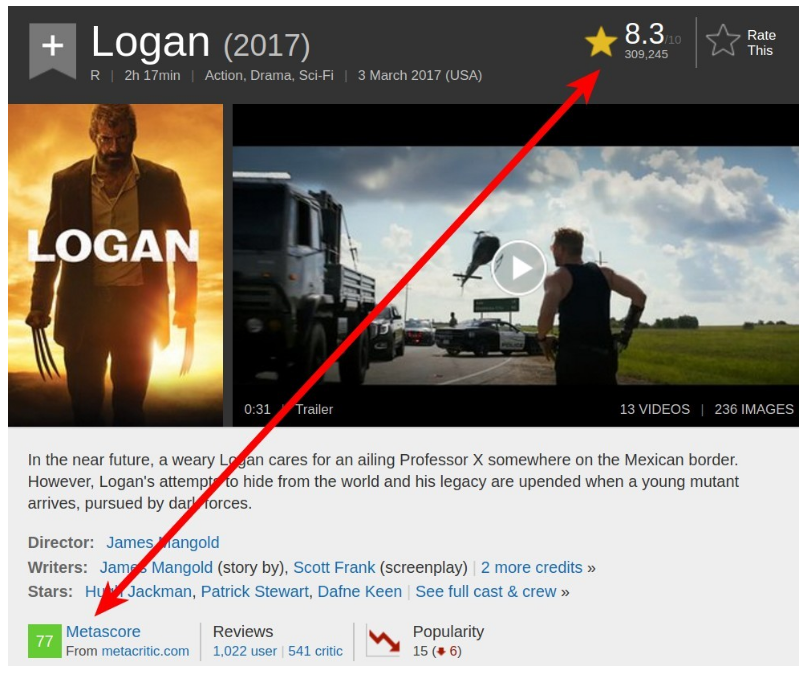

If we investigate the IMDB site further, we can discover the page shown below. It contains all the data we need for 50 movies. Given our aim, this means we’ll only have to do about 40 requests, which is 100 times less than our first option. Let’s explore this last option further.

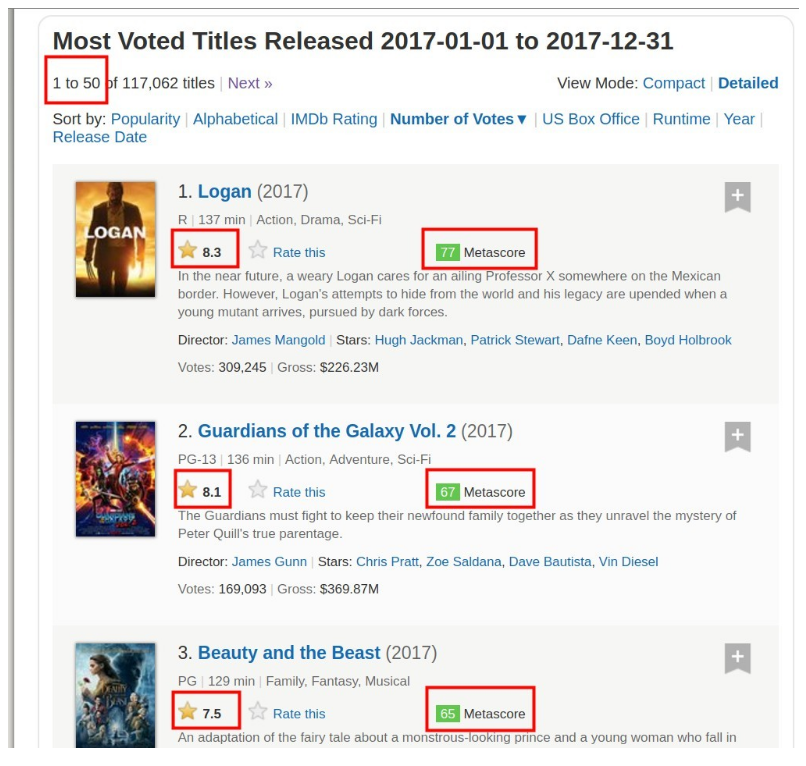

## Identifying the URL structure

Our challenge now is to make sure we understand the logic of the URL as the pages we want to scrape change. If we can’t understand this logic enough so we can implement it into code, then we’ll reach a dead end.

If you go on IMDB’s advanced search page, you can browse movies by [year](https://www.imdb.com/search/title/#releasedate)

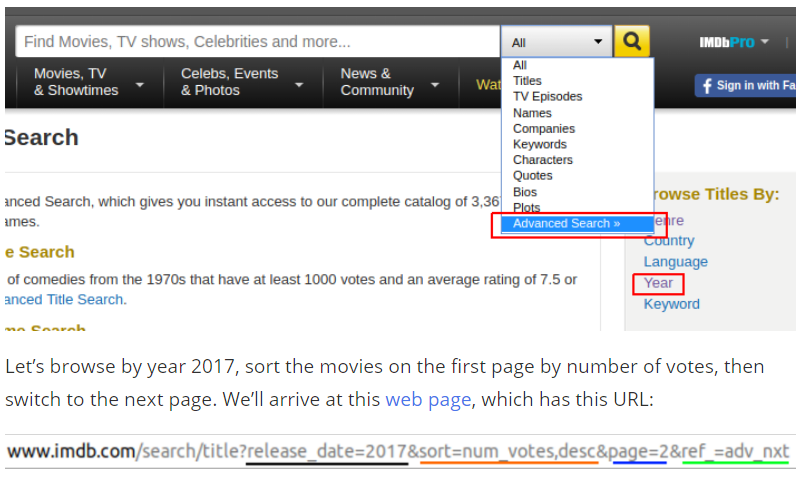

In the image above, you can see that the URL has several parameters after the question mark:

- `release_date` — Shows only the movies released in a specific year.
- `sort` — Sorts the movies on the page. `sort=num_votes`,desc translates to sort by number of votes in a descending order.
- `page` — Specifies the page number.
- `ref_` — Takes us to the the next or the previous page. The reference is the page we are currently on. `adv_nxt` and `adv_prv` are two possible values. They translate to advance to the next page, and advance to the previous page, respectively.

If you navigate through those pages and observe the URL, you will notice that only the values of the parameters change. This means we can write a script to match the logic of the changes and make far fewer requests to scrape our data.

Let’s start writing the script by requesting the content of this single web page: `http://www.imdb.com/search/title?release_date=2017&sort=num_votes,desc&page=1`. In the following code cell we will:

- Import the `get()` function from the requests module.
- Assign the address of the web page to a variable named `url`.
- Request the server the content of the web page by using `get()`, and store the server’s response in the variable `response`.
- Print a small part of response‘s content by accessing its .text attribute (response is now a Response object).

In [1]:
import requests
url = "http://www.imdb.com/search/title?release_date=2017&sort=num_votes,desc&page=1"
response=requests.get(url, headers = {"Accept-Language": "en-US, en;q=0.5"})
print(response.text[:500])



<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
         
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">

    <meta name="apple-itunes-app" content="app-id=342792525, app-argument=imdb:///?src=mdot">



        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>

<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle",


## Understanding the HTML structure of a single page

As you can see from the first line of `response.text`, the server sent us an HTML document. This document describes the overall structure of that web page, along with its specific content (which is what makes that particular page unique).

All the pages we want to scrape have the same overall structure. This implies that they also have the same overall HTML structure. So, to write our script, it will suffice to understand the HTML structure of only one page. To do that, we’ll use the browser’s **Developer Tools**.

If you use Chrome, right-click on a web page element that interests you, and then click Inspect. This will take you right to the HTML line that corresponds to that element:

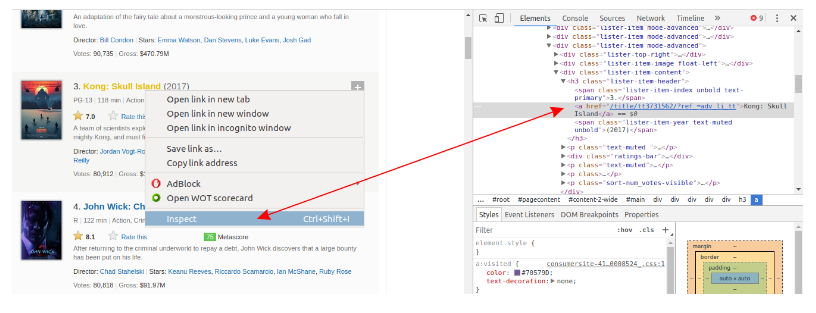

Right-click on the movie’s name, and then left-click Inspect. The HTML line highlighted in gray corresponds to what the user sees on the web page as the movie’s name.

You can also do this using both Firefox and Safari DevTools.

Notice that all of the information for each movie, including the poster, is contained in a `div` tag.

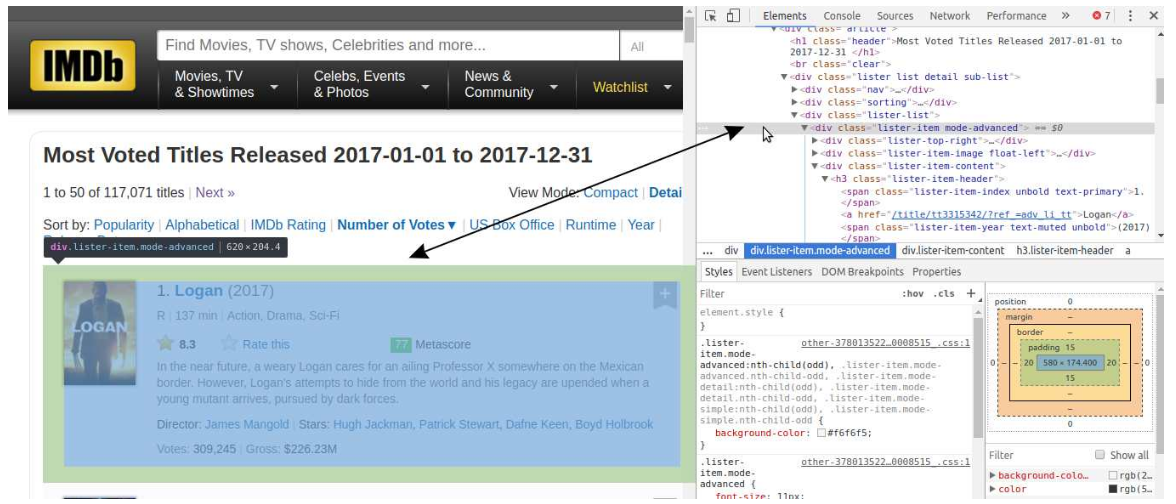

There are a lot of HTML lines nested within each div tag. You can explore them by clicking those little gray arrows on the left of the HTML lines corresponding to each div. Within these nested tags we’ll find the information we need, like a movie’s rating.

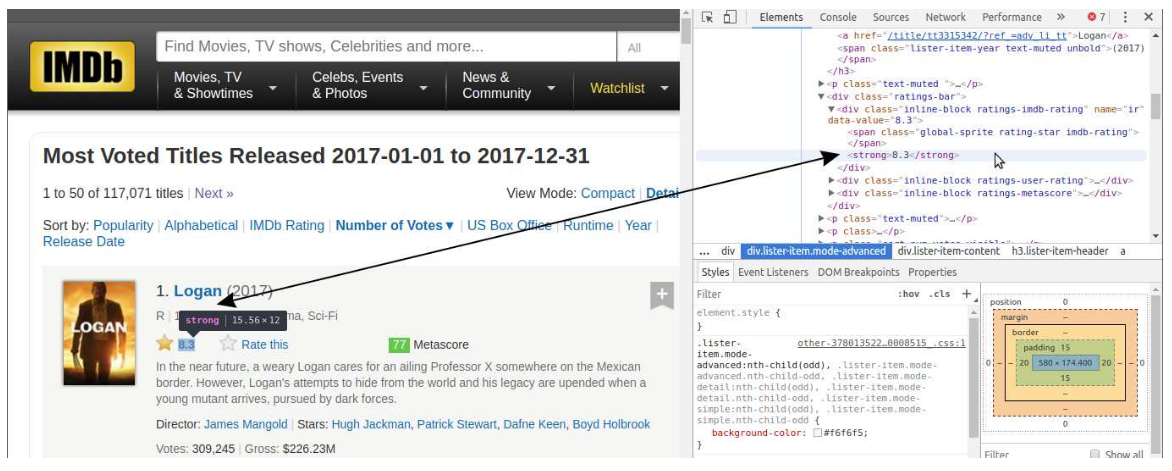

There are 50 movies shown per page, so there should be a div container for each. Let’s extract all these 50 containers by parsing the HTML document from our earlier request.

## Using BeautifulSoup to parse the HTML content

To parse our HTML document and extract the 50 div containers, we’ll use a Python module called BeautifulSoup, the most common web scraping module for Python.

In the following code cell we will:

- Import the BeautifulSoup class creator from the package bs4.
- Parse response.text by creating a BeautifulSoup object, and assign this object to html_soup. The 'html.parser' argument indicates that we want to do the parsing using Python’s built-in HTML parser.

In [2]:
from bs4 import BeautifulSoup
content=response.content
html_soup = BeautifulSoup(content, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

Before extracting the 50 div containers, we need to figure out what distinguishes them from other div elements on that page. Often, the distinctive mark resides in the class attribute. If you inspect the HTML lines of the containers of interest, you’ll notice that the class attribute has two values: `lister-item` and `mode-advanced`. This combination is unique to these div containers. We can see that’s true by doing a quick search (Ctrl + F). We have 50 such containers, so we expect to see only 50 matches:

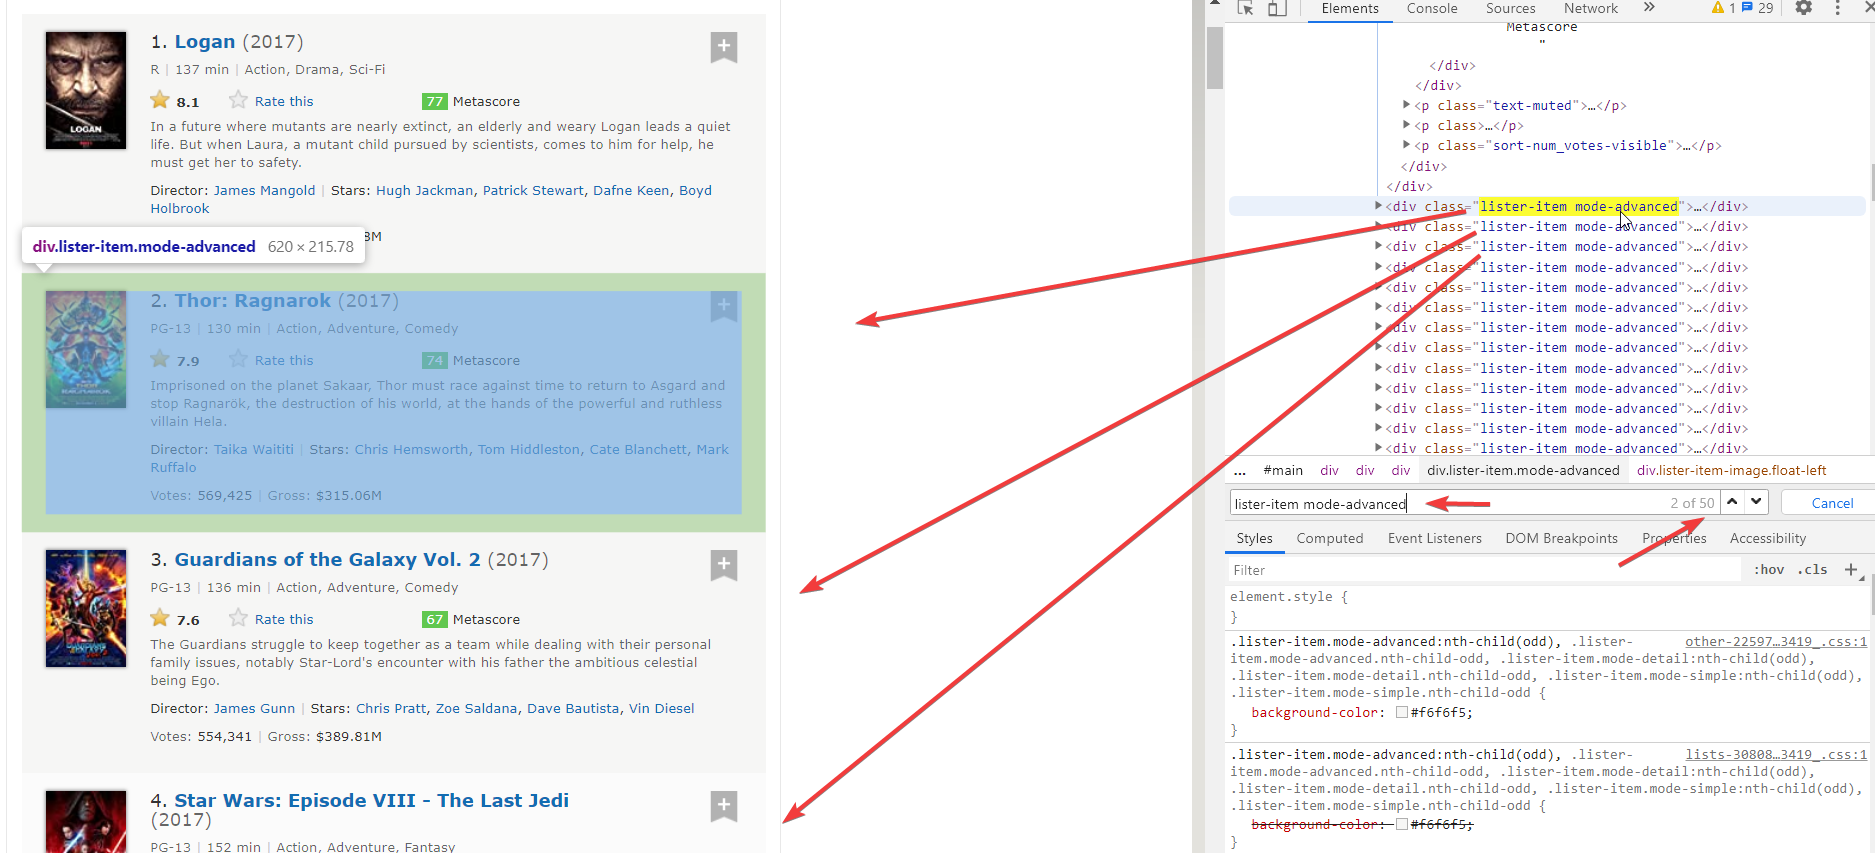

Now let’s use the find_all() method to extract all the div containers that have a class attribute of lister-item mode-advanced:

In [3]:
movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')
print(type(movie_containers))
print(len(movie_containers))

<class 'bs4.element.ResultSet'>
50


`find_all()` returned a `ResultSet` object which is a list containing all the 50 divs we are interested in.

Now we’ll select only the first container, and extract, by turn, each item of interest:

- The name of the movie.
- The year of release.
- The IMDB rating.
- The Metascore.
- The number of votes.
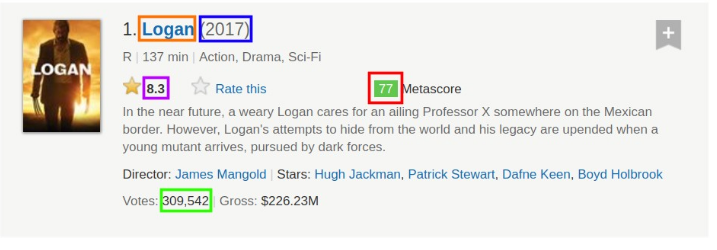

## Extracting the data for a single movie

We can access the first container, which contains information about a single movie, by using list notation on `movie_containers`.

In [4]:
first_movie = movie_containers[0]
first_movie

<div class="lister-item mode-advanced">
<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt3315342"></div>
</div>
<div class="lister-item-image float-left">
<a href="/title/tt3315342/"> <img alt="Logan" class="loadlate" data-tconst="tt3315342" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BYzc5MTU4N2EtYTkyMi00NjdhLTg3NWEtMTY4OTEyMzJhZTAzXkEyXkFqcGdeQXVyNjc1NTYyMjg@._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/G/01/imdb/images/nopicture/large/film-184890147._CB466725069_.png" width="67"/>
</a> </div>
<div class="lister-item-content">
<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt3315342/">Logan</a>
<span class="lister-item-year text-muted unbold">(2017)</span>
</h3>
<p class="text-muted">
<span class="certificate">R</span>
<span class="ghost">|</span>
<span class="runtime">137 min</span>
<span class="ghost">|</span>
<span class="genre">
Act

As you can see, the HTML content of one container is very long. To find out the HTML line specific to each data point, we’ll use DevTools once again.

### The name of the movie

We begin with the movie’s name, and locate its correspondent HTML line by using DevTools. You can see that the name is contained within an anchor tag (`<a>`). This tag is nested within a header tag (`<h3>`). The `<h3>` tag is nested within a `<div>` tag. This `<div>` is the third of the `divs` nested in the container of the first movie. We stored the content of this container in the `first_movie` variable.
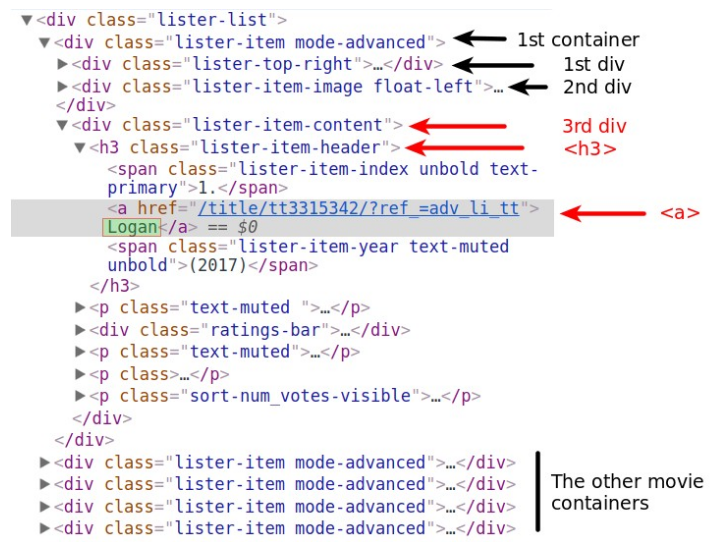

`first_movie` is a `Tag` [object](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#kinds-of-objects), and the various HTML tags within it are stored as its attributes. We can access them just like we would access any attribute of a Python object. However, using a tag name as an attribute will only select the first tag by that name. If we run first_movie.div, we only get the content of the first div tag.

In [5]:
first_movie.div

<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt3315342"></div>
</div>

Accessing the first anchor tag (`<a>`) doesn’t take us to the movie’s name. The first `<a>` is somewhere within the second `div`.

In [6]:
first_movie.a

<a href="/title/tt3315342/"> <img alt="Logan" class="loadlate" data-tconst="tt3315342" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BYzc5MTU4N2EtYTkyMi00NjdhLTg3NWEtMTY4OTEyMzJhZTAzXkEyXkFqcGdeQXVyNjc1NTYyMjg@._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/G/01/imdb/images/nopicture/large/film-184890147._CB466725069_.png" width="67"/>
</a>

However, accessing the first `<h3>` tag brings us very close.

In [7]:
first_movie.h3

<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt3315342/">Logan</a>
<span class="lister-item-year text-muted unbold">(2017)</span>
</h3>

From here, we can use attribute notation to access the first `<a>` inside the `<h3>` tag.

In [8]:
first_movie.h3.a

<a href="/title/tt3315342/">Logan</a>

Now it’s all just a matter of accessing the text from within that `<a>` tag.

In [9]:
first_name = first_movie.h3.a.text
first_name

'Logan'

### The year of the movie’s release

We move on with extracting the year. This data is stored within the `<span>` tag below the `<a>` that contains the name.
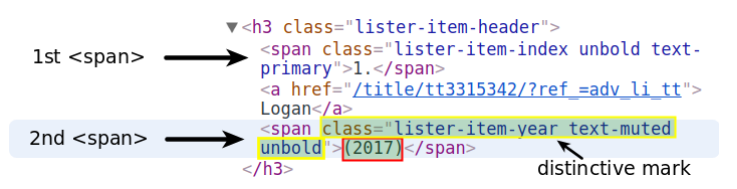

Dot notation will only access the first `span` element. We’ll search by the distinctive mark of the second `<span>`. We’ll use the `find()` [method](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) which is almost the same as `find_all()`, except that it only returns the first match. In fact, `find()` is equivalent to `find_all(limit = 1)`. The [limit argument](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#the-limit-argument) limits the output to the first match.

The distinguishing mark consists of the values `lister-item-year text-muted unbold` assigned to the `class` attribute. So we look for the first `<span>` with these values within the `<h3>` tag.

In [10]:
first_year = first_movie.h3.find('span', class_ = 'lister-item-year text-muted unbold')
first_year

<span class="lister-item-year text-muted unbold">(2017)</span>

From here, we just access the text using attribute notation.

In [11]:
first_year = first_year.text
first_year

'(2017)'

We could easily clean that output and convert it to an integer. But if you explore more pages, you will notice that for some movies the year takes unpredictable values like (2017)(I) or (2015)(V). It’s more efficient to do the cleaning after the scraping, when we’ll know all the year values.

### The IMDB rating

We now focus on extracting the IMDB rating of the first movie.

There are a couple of ways to do that, but we’ll first try the easiest one. If you inspect the IMDB rating using DevTools, you’ll notice that the rating is contained within a `<strong>` [tag](https://www.w3schools.com/tags/tag_strong.asp).
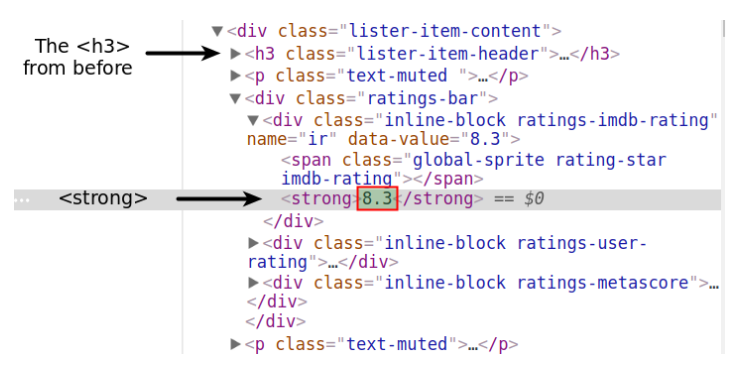

Let’s use attribute notation, and hope that the first `<strong>` will also be the one that contains the rating.

In [12]:
first_movie.strong

<strong>8.1</strong>

Great! We’ll access the text, convert it to the `float` type, and assign it to the variable `first_imdb`.

In [13]:
first_imdb = float(first_movie.strong.text)
first_imdb

8.1

### The Metascore

If we inspect the Metascore using DevTools, we’ll notice that we can find it within a `span` tag.
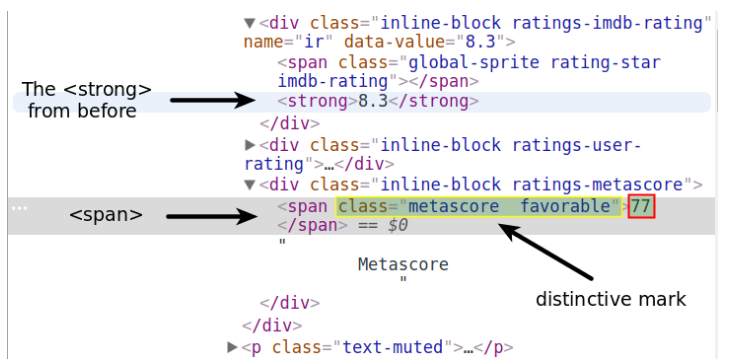

Attribute notation clearly isn’t a solution. There are many `<span>` tags before that. You can see one right above the `<strong>` tag. We’d better use the distinctive values of the `class` attribute (`metascore favorable`).

Note that if you copy-paste those values from DevTools’ tab, there will be two white space characters between `metascore` and `favorable`. Make sure there will be only one whitespace character when you pass the values as arguments to the `class_` parameter. Otherwise, `find()` won’t find anything.

In [14]:
first_mscore = first_movie.find('span', class_ = 'metascore favorable')
first_mscore = int(first_mscore.text)
print(first_mscore)

77


The `favorable` value indicates a high Metascore and sets the rating’s background color to green. The other two possible values are `unfavorable` and `mixed`. What is specific to all Metascore ratings though is only the `metascore` value. This is the one we are going to use when we’ll write the script for the entire page.

### The number of votes

The number of votes is contained within a `<span>` tag. Its distinctive mark is a `name` attribute with the value `nv`.
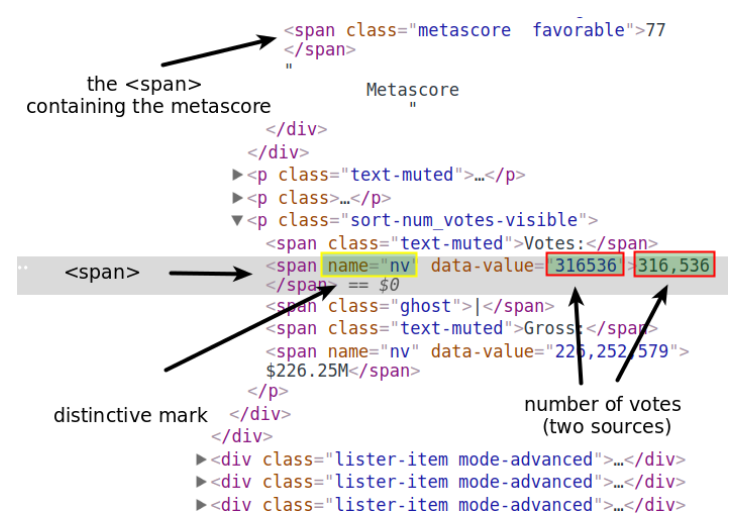

The `name` attribute is different from the `class` attribute. Using BeautifulSoup we can access elements by any attribute. The `find()` and `find_all()` functions have a parameter named `attrs`. To this we can pass in the attributes and values we are searching for as a dictionary.

In [15]:
first_votes = first_movie.find('span', attrs = {'name':'nv'})
first_votes

<span data-value="636592" name="nv">636,592</span>

We could use `.text` notation to access the `<span>` tag’s content. It would be better though if we accessed the value of the `data-value` attribute. This way we can convert the extracted datapoint to an `int` without having to strip a comma.

You can treat a `Tag` object just like a dictionary. The HTML attributes are the dictionary’s keys. The values of the HTML attributes are the values of the dictionary’s keys. This is how we can access the value of the `data-value` attribute.

In [16]:
first_votes=first_votes['data-value']
first_votes

'636592'

Let’s convert that value to an integer, and assign it to `first_votes`.

In [17]:
first_votes = int(first_votes)
first_votes

636592

That’s it! We’re now in a position to easily write a script for scraping a single page.

## The script for a single page

Before piecing together what we’ve done so far, we have to make sure that we’ll extract the data only from the containers that have a Metascore.
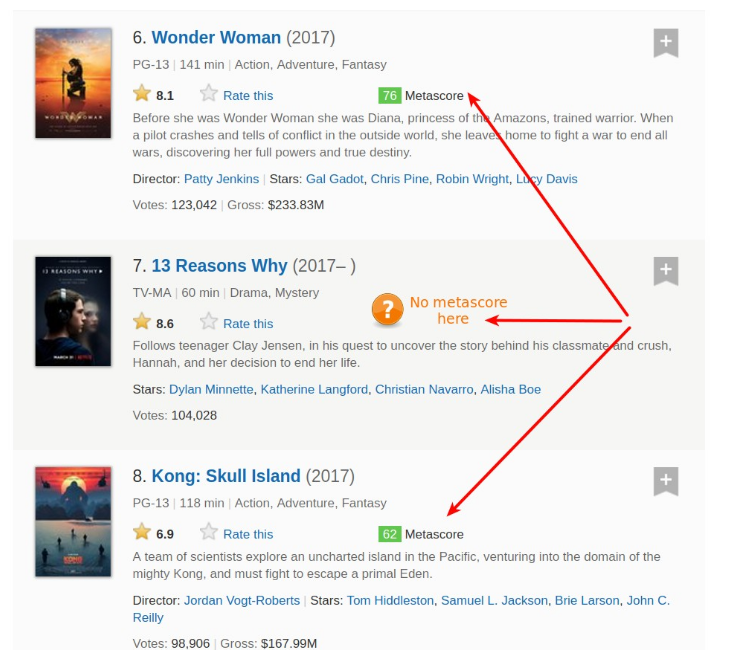

We need to add a condition to skip movies without a Metascore.

Using DevTools again, we see that the Metascore section is contained within a `<div>` tag. The `class` attribute has two values: `inline-block` and `ratings-metascore`. The distinctive one is clearly `ratings-metascore`.
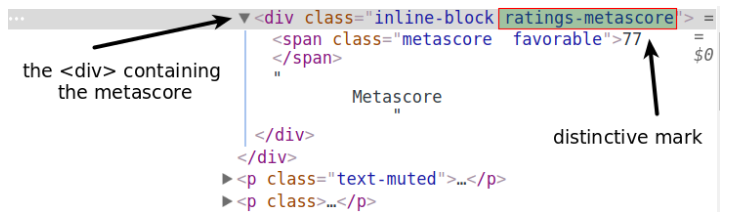

We can use `find()` to search each movie container for a `div` having that distinct mark. When `find()` doesn’t find anything, it returns a `None` object. We can use this result in an `if` statement to control whether a movie is scraped.

Let’s look on the [web page](https://www.imdb.com/search/title/?release_date=2017&sort=num_votes,desc&page=1) to search for a movie container that doesn’t have a Metascore, and see what `find()` returns.

*Important: when I ran the following code, the eighth container didn’t have a Metascore. However, this is a moving target, because the number of votes constantly changes for each movie. To get the same outputs as I did in the next demonstrative code cell, you should search a container that doesn’t have a Metascore at the time you’re running the code.*

In [18]:
eighth_movie_mscore = movie_containers[17].find('div', class_ = 'ratings-metascore')
type(eighth_movie_mscore)

NoneType

Now let’s put together the code above, and compress it as much as possible, but only insofar as it’s still easily readable. In the next code block we:

- Declare some `list` variables to have something to store the extracted data in.
- Loop through each container in `movie_containers` (the variable which contains all the 50 movie containers).
- Extract the data points of interest only if the container has a Metascore.

In [19]:
# Lists to store the scraped data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []
# Extract data from individual movie container
for container in movie_containers:
# If the movie has Metascore, then extract:
    if container.find('div', class_ = 'ratings-metascore') is not None:
    # The name
        name = container.h3.a.text
        names.append(name)
    # The year
        year = container.h3.find('span', class_ = 'lister-item-year').text
        years.append(year)
    # The IMDB rating
        imdb = float(container.strong.text)
        imdb_ratings.append(imdb)
    # The Metascore
        m_score = container.find('span', class_ = 'metascore').text
        metascores.append(int(m_score))
    # The number of votes
        vote = container.find('span', attrs = {'name':'nv'})['data-value']
        votes.append(int(vote))

Let’s check the data collected so far. [Pandas](https://pandas.pydata.org/pandas-docs/stable/) makes it easy for us to see whether we’ve scraped our data successfully.

In [20]:
import pandas as pd
test_df = pd.DataFrame({'movie': names,
'year': years,
'imdb': imdb_ratings,
'metascore': metascores,
'votes': votes
})
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
movie        42 non-null object
year         42 non-null object
imdb         42 non-null float64
metascore    42 non-null int64
votes        42 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ KB
None


movie        year  imdb  \
0                                              Logan      (2017)   8.1   
1                                     Thor: Ragnarok      (2017)   7.9   
2                     Guardians of the Galaxy Vol. 2      (2017)   7.6   
3            Star Wars: Episode VIII - The Last Jedi      (2017)   7.0   
4                                            Dunkirk      (2017)   7.9   
5                                       Wonder Woman      (2017)   7.4   
6                             Spider-Man: Homecoming      (2017)   7.4   
7                                            Get Out  (I) (2017)   7.7   
8                                                 It  (I) (2017)   7.3   
9                                  Blade Runner 2049      (2017)   8.0   
10                                       Baby Driver      (2017)   7.6   
11         Three Billboards Outside Ebbing, Missouri      (2017)   8.2   
12                                    Justice League      (2017)   6.3   
13                                              Coco  (I) (2017)   8.4   
14                                The Shape of Water      (2017)   7.3   
15                              John Wick: Chapter 2      (2017)   7.5   
16                    Jumanji: Welcome to the Jungle      (2017)   6.9   
17                              Beauty and the Beast  (I) (2017)   7.1   
18                       Kingsman: The Golden Circle      (2017)   6.7   
19                                Kong: Skull Island      (2017)   6.6   
20  Pirates of the Caribbean: Dead Men Tell No Tales      (2017)   6.6   
21                                   Alien: Covenant      (2017)   6.4   
22                                         Lady Bird      (2017)   7.4   
23                              The Greatest Showman      (2017)   7.6   
24                    War for the Planet of the Apes      (2017)   7.4   
25                      Murder on the Orient Express      (2017)   6.5   
26                              Call Me by Your Name      (2017)   7.9   
27                                              Life  (I) (2017)   6.6   
28                           The Fate of the Furious      (2017)   6.7   
29                                        Wind River      (2017)   7.7   
30                                Ghost in the Shell      (2017)   6.3   
31                  King Arthur: Legend of the Sword      (2017)   6.7   
32                                           Mother!      (2017)   6.6   
33                            The Hitman's Bodyguard      (2017)   6.9   
34                                          I, Tonya      (2017)   7.5   
35                                     Atomic Blonde      (2017)   6.7   
36                                         The Mummy      (2017)   5.4   
37                                      Darkest Hour      (2017)   7.4   
38                                            Bright  (I) (2017)   6.3   
39       Valerian and the City of a Thousand Planets      (2017)   6.5   
40                                          Baywatch      (2017)   5.5   
41                                     American Made      (2017)   7.2   

    metascore   votes  
0          77  636592  
1          74  574514  
2          67  558770  
3          84  554240  
4          94  542245  
5          76  542045  
6          73  501627  
7          85  482410  
8          69  452339  
9          81  450439  
10         86  430038  
11         88  420145  
12         45  376640  
13         81  364815  
14         87  362954  
15         75  358226  
16         58  313623  
17         65  268751  
18         44  267951  
19         62  264704  
20         39  258506  
21         65  251161  
22         94  234827  
23         48  231784  
24         82  224705  
25         52  208748  
26         93  205046  
27         54  204962  
28         56  201625  
29         73  198682  
30         52  193395  
31         41  189213  
32         75  187979  
33         47  183560  
34         77  177330  


Everything went just as expected!

As a side note, if you run the code from a country where English is not the main language, it’s very likely that you’ll get some of the movie names translated into the main language of that country.

Most likely, this happens because the server infers your location from your IP address. Even if you are located in a country where English is the main language, you may still get translated content. This may happen if you’re using a VPN while you’re making the `GET` requests.

If you run into this issue, pass the following values to the `headers` parameter of the `get()` function.

In [21]:
headers = {"Accept-Language": "en-US, en;q=0.5"}

This will communicate the server something like *“I want the linguistic content in American English (en-US). If en-US is not available, then other types of English (en) would be fine too (but not as much as en-US).”*. The `q` parameter indicates the degree to which we prefer a certain language. If not specified, then the values is set to `1` by default, like in the case of en-US. You can read more about this [here](https://www.w3.org/Protocols/rfc2616/rfc2616-sec14.html#sec14.4).

Now let’s start building the script for all the pages we want to scrape.

## The script for multiple pages

Scraping multiple pages is a bit more challenging. We’ll build upon our one-page script by doing three more things:

1. Making all the requests we want from within the loop.
2. Controlling the loop’s rate to avoid bombarding the server with requests.
3. Monitoring the loop while it runs.

We’ll scrape the first 4 pages of each year in the interval 2000-2017. 4 pages for each of the 18 years makes for a total of 72 pages. Each page has 50 movies, so we’ll scrape data for 3600 movies at most. But not all the movies have a Metascore, so the number will be lower than that. Even so, we are still very likely to get data for over 2000 movies.

### Changing the URL’s parameters

As shown earlier, the URLs follow a certain logic as the web pages change.
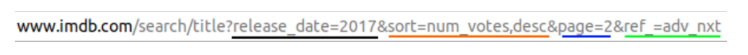

As we are making the requests, we’ll only have to vary the values of only two parameters of the URL: the `release_date` parameter, and `page`. Let’s prepare the values we’ll need for the forthcoming loop. In the next code cell we will:

- Create a list called pages, and populate it with the **strings** corresponding to the first 4 pages.
- Create a list called years_url and populate it with the **strings** corresponding to the years 2000-2017.

In [22]:
pages = [str(i) for i in range(1,5)]
years_url = [str(i) for i in range(2000,2018)]

### Controlling the crawl-rate

Controlling the rate of crawling is beneficial for us, and for the website we are scraping. If we avoid hammering the server with tens of requests per second, then we are much less likely to get our IP address banned. We also avoid disrupting the activity of the website we scrape by allowing the server to respond to other users’ requests too.

We’ll control the loop’s rate by using the `sleep()` [function](https://docs.python.org/3/library/time.html?highlight=time%20module#time.sleep) from Python’s `time` [module](https://docs.python.org/3/library/time.html?highlight=time%20module#module-time). `sleep()` will pause the execution of the loop for a specified amount of seconds.

To mimic human behavior, we’ll vary the amount of waiting time between requests by using the `randint()` [function](https://docs.python.org/3/library/random.html?highlight=random%20module#random.randint) from the Python’s `random` [module](https://docs.python.org/3/library/random.html?highlight=random%20module#module-random). `randint()` randomly generates integers within a specified interval.
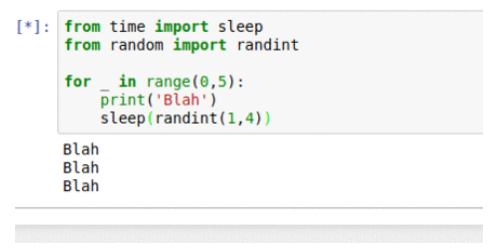

For now, let’s just import these two functions to prevent overcrowding in the code cell containing our main sleep from loop.

In [23]:
from time import sleep
from random import randint

### Monitoring the loop as it’s still going

Given that we’re scraping 72 pages, it would be nice if we could find a way to monitor the scraping process as it’s still going. This feature is definitely optional, but it can be very helpful in the testing and debugging process. Also, the greater the number of pages, the more helpful the monitoring becomes. If you are going to scrape hundreds or thousands of web pages in a single code run, I would say that this feature becomes a must.

For our script, we’ll make use of this feature, and monitor the following parameters:

- The **frequency (speed) of requests**, so we make sure our program is not overloading the server.
- The **number of requests**, so we can halt the loop in case the number of expected requests is exceeded.
- The [status code](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes) of our requests, so we make sure the server is sending back the proper responses.

To get a frequency value we’ll divide the number of requests by the time elapsed since the first request. This is similar to computing the speed of a car – we divide the distance by the time taken to cover that distance. Let’s experiment with this monitoring technique at a small scale first. In the following code cell we will:

- Set a starting time using the `time()` function(https://docs.python.org/3/library/time.html?highlight=time%20module#time.time) from the `time` [module](https://docs.python.org/3/library/time.html?highlight=time%20module#module-time), and assign the value to `start_time`.
- Assign 0 to the variable `requests` which we’ll use to count the number of requests.
- Start a loop, and then with each iteration:
    - Simulate a request.
    - Increment the number of requests by 1.
    - Pause the loop for a time interval between 8 and 15 seconds.
    - Calculate the elapsed time since the first request, and assign the value to `elapsed_time`.
    - Print the number of requests and the frequency.

In [24]:
from time import time
start_time = time()
requests = 0
for _ in range(5):
# A request would go here
    requests += 1
    sleep(randint(1,3))
    elapsed_time = time() - start_time
    print('Request: {}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))

Request: 1; Frequency: 0.49660835394787456 requests/s
Request: 2; Frequency: 0.3984985086841961 requests/s
Request: 3; Frequency: 0.49730057526495086 requests/s
Request: 4; Frequency: 0.5684451188161044 requests/s
Request: 5; Frequency: 0.5522947711957517 requests/s


Since we’re going to make 72 requests, our work will look a bit untidy as the output accumulates. To avoid that, we’ll clear the output after each iteration, and replace it with information about the most recent request. To do that we’ll use the `clear_output()`[function](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html#IPython.core.display.clear_output) from the IPython’s `core.display` [module](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html#module-IPython.core.display). We’ll set the `wait` parameter of `clear_output()` to `True` to wait with replacing the current output until some new output appears.

In [25]:
from IPython.core.display import clear_output
start_time = time()
requests = 0
for _ in range(5):
# A request would go here
    requests += 1
    sleep(randint(1,3))
    current_time = time()
    elapsed_time = current_time - start_time
    print('Request: {}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)

Request: 5; Frequency: 0.49627954572012517 requests/s


The output above is the output you will see once the loop has run.

To monitor the status code we’ll set the program to warn us if there’s something off. A [successful request](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes#2xx_Success) is indicated by a status code of 200. We’ll use the `warn()` [function](https://www.dataquest.io/blog/web-scraping-beautifulsoup/) from the `warnings` module to throw a warning if the status code is not 200.

In [26]:
from warnings import warn
warn("Warning Simulation")

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Warning Simulation
  


We chose a warning over breaking the loop because there’s a good possibility we’ll scrape enough data, even if some of the requests fail. We will only break the loop if the number of requests is greater than expected.

### Piecing everything together

Now let’s piece together everything we’ve done so far! In the following code cell, we start by:

- Redeclaring the lists variables so they become empty again.
- Preparing the monitoring of the loop.

Then, we’ll:

- Loop through the `years_url` list to vary the `release_date` parameter of the URL.
- For each element in `years_url`, loop through the `pages` list to vary the `page` parameter of the URL.
- Make the `GET` requests within the pages loop (and give the headers parameter the right value to make sure we get only English content).
- Pause the loop for a time interval between 8 and 15 seconds.
- Monitor each request as discussed before.
- Throw a warning for non-200 status codes.
- Break the loop if the number of requests is greater than expected.
- Convert the `response‘s` HTML content to a `BeautifulSoup` object.
- Extract all movie containers from this `BeautifulSoup` object.
- Loop through all these containers.
- Extract the data if a container has a Metascore.

In [27]:
import requests as req
pages = [str(i) for i in range(1,5)]
years_url = [str(i) for i in range(2000,2018)]

# Redeclaring the lists to store data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []

# Preparing the monitoring of the loop
start_time = time()
requests = 0

# For every year in the interval 2000-2017
for year_url in years_url:
    
    # For every page in the interval 1-4
    for page in pages:
        
        # Make a get request
        url = "http://www.imdb.com/search/title?release_date="+year_url+"&sort=num_votes,desc&page="+page
        response = req.get(url, headers = headers)
        
        # Pause the loop
        sleep(randint(8,15))
        
        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        clear_output(wait = True)
        
        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        # Break the loop if the number of requests is greater than expected
        if requests > 72:
            warn('Number of requests was greater than expected.')
            break
            
        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')
        
        # Select all the 50 movie containers from a single page
        mv_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')
        
        # For every movie of these 50
        for container in mv_containers:
            # If the movie has a Metascore, then:
            if container.find('div', class_ = 'ratings-metascore') is not None:
                
                # Scrape the name
                name = container.h3.a.text
                names.append(name)
                
                # Scrape the year
                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)
                
                # Scrape the IMDB rating
                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)
                
                # Scrape the Metascore
                m_score = container.find('span', class_ = 'metascore').text
                metascores.append(int(m_score))
                
                # Scrape the number of votes
                vote = container.find('span', attrs = {'name':'nv'})['data-value']
                votes.append(int(vote))

Request:72; Frequency: 0.07495802328041337 requests/s


Nice! The scraping seems to have worked perfectly. The script ran for about 16 minutes.

Now let’s merge the data into a pandas `DataFrame` to examine what we’ve managed to scrape. If everything is as expected, we can move on with cleaning the data to get it ready for analysis.

## Examining the scraped data

In the next code block we:

- Merge the data into a pandas `DataFrame.
- Print some informations about the newly created `DataFrame`.
- Show the first 10 entries.

In [29]:
movie_ratings = pd.DataFrame({'movie': names,
'year': years,
'imdb': imdb_ratings,
'metascore': metascores,
'votes': votes
})
print(movie_ratings.info())
movie_ratings.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 5 columns):
movie        3272 non-null object
year         3272 non-null object
imdb         3272 non-null float64
metascore    3272 non-null int64
votes        3272 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 127.9+ KB
None


movie    year  imdb  metascore    votes
0               Gladiator  (2000)   8.5         67  1322514
1                 Memento  (2000)   8.4         80  1111309
2                  Snatch  (2000)   8.3         55   773218
3     Requiem for a Dream  (2000)   8.3         68   756812
4                   X-Men  (2000)   7.4         64   565882
5               Cast Away  (2000)   7.8         73   516195
6         American Psycho  (2000)   7.6         64   481426
7             Unbreakable  (2000)   7.3         62   383207
8  Mission: Impossible II  (2000)   6.1         59   311376
9        Meet the Parents  (2000)   7.0         73   308424

The output of `info()` shows we collected data for well over 3000 movies. We can also see that there are no null values in our dataset whatsoever.

I have checked the ratings of these first 10 movies against the IMDB’s website. They were all correct. You may want to do the same thing yourself.

We can safely proceed with cleaning the data.

## Cleaning the scraped data

We’ll clean the scraped data with two goals in mind: plotting the distribution of IMDB and Metascore ratings, and sharing the dataset. Consequently, our data cleaning will consist of:

- Reordering the columns.
- Cleaning the year column and convert the values to integers.
- Checking the extreme rating values to determine if all the ratings are within the expected intervals.
- Normalizing one of the ratings type (or both) for generating a comparative [histogram](https://datavizcatalogue.com/methods/histogram.html).

Let’s start by reordering the columns:

In [30]:
movie_ratings = movie_ratings[['movie', 'year', 'imdb', 'metascore', 'votes']]
movie_ratings.head()

movie    year  imdb  metascore    votes
0            Gladiator  (2000)   8.5         67  1322514
1              Memento  (2000)   8.4         80  1111309
2               Snatch  (2000)   8.3         55   773218
3  Requiem for a Dream  (2000)   8.3         68   756812
4                X-Men  (2000)   7.4         64   565882

Now let’s convert all the values in the `year` column to integers.

Right now all the values are of the `object` type. To avoid `ValueErrors` upon conversion, we want the values to be composed only from numbers from 0 to 9.

Let’s examine the unique values of the `year` column. This helps us to get an idea of what we could do to make the conversions we want. To see all the unique values, we’ll use the `unique()` method:

In [31]:
movie_ratings['year'].unique()

array(['(2000)', '(I) (2000)', '(2001)', '(2002)', '(2003)', '(2004)',
       '(I) (2004)', '(2005)', '(I) (2005)', '(2006)', '(I) (2006)',
       '(2007)', '(I) (2007)', '(2008)', '(I) (2008)', '(2009)',
       '(I) (2009)', '(2010)', '(I) (2010)', '(2011)', '(I) (2011)',
       '(2012)', '(I) (2012)', '(2013)', '(I) (2013)', '(2014)',
       '(I) (2014)', '(II) (2014)', '(2015)', '(I) (2015)', '(II) (2015)',
       '(2016)', '(II) (2016)', '(IX) (2016)', '(I) (2016)', '(2017)',
       '(I) (2017)'], dtype=object)

Counting from the end toward beginning, we can see that the years are always located from the fifth character to the second. We’ll use the `.str()` [method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.html) to select only that interval. We’ll also convert the result to an integer using the `astype()` [method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.astype.html).

In [32]:
movie_ratings.loc[:, 'year'] = movie_ratings['year'].str[-5:-1].astype(int)

Let’s visualize the first 3 values of the `year` column for a quick check. We can also see the type of the values on the last line of the output.

In [33]:
movie_ratings['year'].head(3)

0    2000
1    2000
2    2000
Name: year, dtype: int32

Now we’ll check the minimum and maximum values of each type of rating. We can do this very quickly by using pandas’ `describe()` [method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html). When applied on a `DataFrame`, this method returns various descriptive statistics for each numerical column of the `DataFrame`. In the next line of code we select only those rows that describe the minimum and maximum values, and only those columns which describe IMDB ratings and Metascores.

In [34]:
movie_ratings.describe().loc[['min', 'max'], ['imdb', 'metascore']]

imdb  metascore
min   4.1       24.0
max   9.0      100.0

There are no unexpected outliers.

From the values above, you can see that the two ratings have different scales. To be able to plot the two distributions on a single graph, we’ll have to bring them to the same scale. Let’s normalize the `imdb` column to a 100-points scale.

We’ll multiply each IMDB rating by 10, and then we’ll do a quick check by looking at the first 3 rows.

In [35]:
movie_ratings['n_imdb'] = movie_ratings['imdb'] * 10
movie_ratings.head(3)

movie  year  imdb  metascore    votes  n_imdb
0  Gladiator  2000   8.5         67  1322514    85.0
1    Memento  2000   8.4         80  1111309    84.0
2     Snatch  2000   8.3         55   773218    83.0

Nice! We are now in a position to save this dataset locally, so we can share it with others more easily. I have already shared it publicly on my [GitHub profile](https://github.com/mircealex/Scraped_dataset_movie_ratings). There are other places where you can share a dataset, like [Kaggle](https://www.kaggle.com/datasets), or [Dataworld](https://data.world/).

So let’s save it.

In [36]:
movie_ratings.to_csv('movie_ratings.csv')

As a side note, I strongly recommend saving the scraped dataset before exiting (or restarting) your notebook kernel. This way you will only have to import the dataset when you resume working, and don’t have to run the scraping script again. This becomes extremely useful if you scrape hundreds or thousands of web pages.

Finally, let’s plot the distributions!

## Plotting and analyzing the distributions

In the following code cell we:

- Import the `matplotlib.pyplot` submodule.
- Run the Jupyter magic `%matplotlib` to activate Jupyter’s matplotlib mode and add `inline` to have our graphs displayed inside the notebook.
- Create a `figure` object with 3 `axes`.
- Plot the distribution of each unnormalized rating on an individual `ax`.
- Plot the normalized distributions of the two ratings on the same `ax`.
- Hide the top and right spines of all the three `axes`.

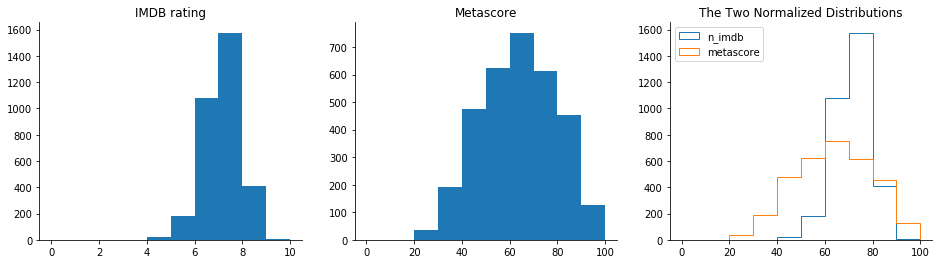

In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
ax1, ax2, ax3 = fig.axes
ax1.hist(movie_ratings['imdb'], bins = 10, range = (0,10)) # bin range = 1
ax1.set_title('IMDB rating')
ax2.hist(movie_ratings['metascore'], bins = 10, range = (0,100)) # bin range = 10
ax2.set_title('Metascore')
ax3.hist(movie_ratings['n_imdb'], bins = 10, range = (0,100), histtype = 'step')
ax3.hist(movie_ratings['metascore'], bins = 10, range = (0,100), histtype = 'step')
ax3.legend(['n_imdb', 'metascore'], loc ='upper left')
ax3.set_title('The Two Normalized Distributions')
for ax in fig.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()

Starting with the IMDB histogram, we can see that most ratings are between 6 and 8. There are few movies with a rating greater than 8, and even fewer with a rating smaller than 6. This indicates that both very good movies and very bad movies are rarer.

The distribution of Metascore ratings resembles a [normal distribution](https://www.mathsisfun.com/data/standard-normal-distribution.html) – most ratings are average, peaking at the value of approximately 65. From this peak, the frequencies gradually decrease toward extreme rating values. According to this distribution, there are indeed fewer very good and very bad movies, but not that few as the IMDB ratings indicate.

On the comparative graph, it’s clearer that the IMDB distribution is highly skewed toward the higher part of the average ratings, while the Metascore ratings seem to have a much more balanced distribution.

What might be the reason for that skew in the IMDB distribution? One hypothesis is that many users tend to have a binary method of assessing movies. If they like the movie, they give it a 10. If they don’t like the movie, they give it a very small rating, or they don’t bother to rate the movie. This an interesting problem that’s worth being explored in more detail.

## Next steps

We’ve come a long way from requesting the content of a single web page to analyzing ratings for over 2000 movies. You should now know how to scrape many web pages with the same HTML and URL structure.

To build upon what we’ve learned, here are a few next steps to consider:

- Scrape data for different time and page intervals.
- Scrape additional data about the movies.
- Find a different website to scrape something that interests you. For example, you could scrape data about [laptops](https://www.walmart.com/browse/electronics/laptop-computers/hp/3944_3951_132960/YnJhbmQ6SFAie?page=1#searchProductResult) to see how prices vary over time.